# Number of Days Before Adoption

In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
### loading in shelter data
shelter_data = pd.read_csv('./Animal_Shelter_Data.csv')
shelter_data.head(3)

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,RAZOR,DOG,BOSTON TERRIER,BLACK/WHITE,Neutered,SMALL,10/29/2009,K22-043412,TRUCK,A396382,...,FIELD,RETURN TO OWNER,FLD_IDTAG,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.43807, -122.71247)",1
1,NaN,OTHER,PIGEON,GRAY/WHITE,Unknown,SMALL,NaN,K23-044095,TRUCK,A416206,...,FIELD,EUTHANIZE,INJ SEVERE,UNKNOWN,HEALTHY,SANTA ROSA,NaN,NaN,NaN,1
2,MAX,DOG,BORDER COLLIE,BLACK/TRICOLOR,Neutered,MED,03/10/2020,K23-044090,DS80,A399488,...,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,UNKNOWN,PENDING,COUNTY,COUNTY,95472.0,"95472(38.40179, -122.82512)",1


In [4]:
shelter_data.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth',
       'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Date',
       'Outcome Date', 'Days in Shelter', 'Intake Type', 'Intake Subtype',
       'Outcome Type', 'Outcome Subtype', 'Intake Condition',
       'Outcome Condition', 'Intake Jurisdiction', 'Outcome Jurisdiction',
       'Outcome Zip Code', 'Location', 'Count'],
      dtype='object')

In [5]:
### filtering on animals that are ultimately adopted
adopted_all = shelter_data[shelter_data['Outcome Type'] == 'ADOPTION']
adopted_all.head(3)

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
10,*TABITHA,CAT,DOMESTIC SH,BLACK,Spayed,KITTN,07/14/2022,K22-042942,LOBBY,A413866,...,OVER THE COUNTER,ADOPTION,WALKIN,HEALTHY,HEALTHY,SANTA ROSA,COUNTY,95589.0,"95589(40.06054, -123.96838)",1
13,*PEPPER,CAT,DOMESTIC SH,BLACK/WHITE,Neutered,KITTN,08/29/2022,K22-042992,CA02,A413965,...,OVER THE COUNTER,ADOPTION,WALKIN,HEALTHY,HEALTHY,COUNTY,SANTA ROSA,95403.0,"95403(38.51311, -122.75502)",1
18,SIR DUNCAN NEPAL,DOG,NEWFOUNDLAND/MIX,BLACK/WHITE,Neutered,X-LRG,08/07/2017,K20-036379,DS82,A399409,...,OVER THE COUNTER,ADOPTION,REFERRAL-F,UNKNOWN,PENDING,SANTA ROSA,*PETALUMA,94954.0,"94954(38.2581, -122.63753)",1


In [6]:
### keeping only relevant columns
adopted = adopted_all[['Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth', 'Intake Date','Days in Shelter', 
                       'Intake Type', 'Intake Subtype', 'Intake Condition', 'Intake Jurisdiction']]
adopted = adopted.reset_index(drop=True)
adopted.head(3)

,Type,Breed,Color,Sex,Size,Date Of Birth,Intake Date,Days in Shelter,Intake Type,Intake Subtype,Intake Condition,Intake Jurisdiction
0,CAT,DOMESTIC SH,BLACK,Spayed,KITTN,07/14/2022,10/25/2022,63,STRAY,OVER THE COUNTER,HEALTHY,SANTA ROSA
1,CAT,DOMESTIC SH,BLACK/WHITE,Neutered,KITTN,08/29/2022,10/29/2022,59,STRAY,OVER THE COUNTER,HEALTHY,COUNTY
2,DOG,NEWFOUNDLAND/MIX,BLACK/WHITE,Neutered,X-LRG,08/07/2017,08/07/2020,20,OWNER SURRENDER,OVER THE COUNTER,UNKNOWN,SANTA ROSA


In [7]:
### creating a feature for animal age at intake time
adopted = adopted[~adopted['Date Of Birth'].isna()]
adopted = adopted.reset_index(drop=True)
adopted['age'] = (pd.to_datetime(adopted['Intake Date'], format='%m/%d/%Y') - pd.to_datetime(adopted['Date Of Birth'], 
                                                                                            format='%m/%d/%Y')).dt.days
adopted = adopted.drop(columns=['Intake Date', 'Date Of Birth'])
adopted = adopted.fillna('nan')
adopted.head(3)

,Type,Breed,Color,Sex,Size,Days in Shelter,Intake Type,Intake Subtype,Intake Condition,Intake Jurisdiction,age
0,CAT,DOMESTIC SH,BLACK,Spayed,KITTN,63,STRAY,OVER THE COUNTER,HEALTHY,SANTA ROSA,103
1,CAT,DOMESTIC SH,BLACK/WHITE,Neutered,KITTN,59,STRAY,OVER THE COUNTER,HEALTHY,COUNTY,61
2,DOG,NEWFOUNDLAND/MIX,BLACK/WHITE,Neutered,X-LRG,20,OWNER SURRENDER,OVER THE COUNTER,UNKNOWN,SANTA ROSA,1096


In [8]:
test = adopted[adopted['Days in Shelter'] <= 200]

In [10]:
adopted['log_days'] = np.log1p(adopted['Days in Shelter'])

In [11]:
### test train split

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(adopted.drop(['Days in Shelter', 'log_days'], axis=1), 
                                                    adopted['log_days'], test_size=0.2, random_state=42)

In [12]:
# Creating and training a CatBoost regression model
model = CatBoostRegressor(cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8], loss_function='MAE', verbose=500)

parameters = {'depth'         : [3, 5, 7, 9],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [500, 1000, 1500]
                 }

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2)
grid.fit(X_train, y_train)

0:	learn: 0.6651078	total: 48.5ms	remaining: 24.2s
499:	learn: 0.5173501	total: 783ms	remaining: 0us
0:	learn: 0.6768126	total: 2.66ms	remaining: 1.32s
499:	learn: 0.5336082	total: 734ms	remaining: 0us
0:	learn: 0.6592251	total: 2.6ms	remaining: 1.29s
499:	learn: 0.4779897	total: 745ms	remaining: 0us
0:	learn: 0.6702145	total: 2.64ms	remaining: 1.32s
499:	learn: 0.4889949	total: 782ms	remaining: 0us
0:	learn: 0.6520357	total: 2.14ms	remaining: 1.07s
499:	learn: 0.4589413	total: 745ms	remaining: 0us
0:	learn: 0.6620974	total: 1.99ms	remaining: 995ms
499:	learn: 0.4682575	total: 928ms	remaining: 0us
0:	learn: 0.6651078	total: 2.04ms	remaining: 2.04s
500:	learn: 0.5173043	total: 855ms	remaining: 851ms
999:	learn: 0.4989638	total: 1.78s	remaining: 0us
0:	learn: 0.6768126	total: 2.65ms	remaining: 2.64s
500:	learn: 0.5334506	total: 807ms	remaining: 804ms
999:	learn: 0.5126675	total: 1.58s	remaining: 0us
0:	learn: 0.6592251	total: 2.53ms	remaining: 2.53s
500:	learn: 0.4779809	total: 763ms	rem

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f43998ac5b0>,
             param_grid={'depth': [3, 5, 7, 9], 'iterations': [500, 1000, 1500],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [13]:
grid.best_params_

{'depth': 9, 'iterations': 1500, 'learning_rate': 0.01}

In [14]:
model = CatBoostRegressor(cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8], loss_function='MAE', verbose=500,
                         depth=9, iterations=1500, learning_rate=0.05)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

0:	learn: 0.6703527	total: 18.8ms	remaining: 28.3s
500:	learn: 0.4656718	total: 8.1s	remaining: 16.1s
1000:	learn: 0.4207145	total: 16.6s	remaining: 8.27s
1499:	learn: 0.3857663	total: 26.1s	remaining: 0us


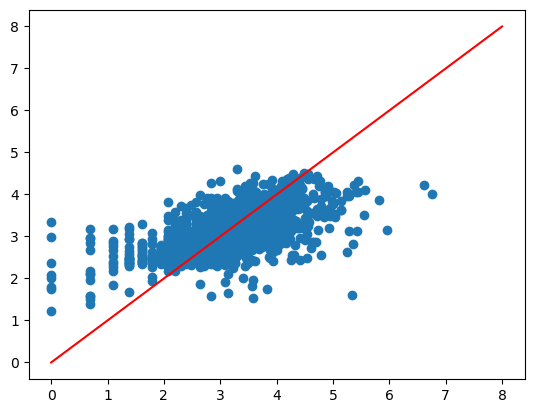

In [16]:
x = np.linspace(0, 8, 100)
y = x

plt.plot(x, y, color='red');
plt.scatter(x=y_test, y=predictions);
plt.show()

In [14]:
feature_importance = model.get_feature_importance()

# Create a dictionary to store the feature importance scores with their corresponding feature names
feature_importance_dict = dict(zip(X_train.columns, feature_importance))

# Sort the features by their importance scores in descending order and get the top N features
n = 10  # number of top features to select
top_features = sorted(feature_importance_dict, key=feature_importance_dict.get, reverse=True)[:n]

# Print the top N features
print(f"Top {n} Features:")
for feature in top_features:
    print(f"{feature}: {feature_importance_dict[feature]}")

Top 10 Features:
age: 17.37831980781531
Color: 13.384210745426294
Size: 10.54400616631359
Intake Condition: 10.404406589511911
Breed: 9.5344276492955
Intake Type: 9.36074959502394
Intake Subtype: 8.947070989951765
Intake Jurisdiction: 7.1475461122126
Sex: 6.766996833848723
Type: 6.532265510600237
